In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import os
import sys
import warnings

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, r2_score

from concepts import concept_instances
from utils import load_data, prepare_folders

In [3]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
data = load_data()
for concept in concept_instances.values():
    concept.prepare_data(data, max_size=5000)

Concept: all lives (b), dataset size: 3236
Concept: last life (b), dataset size: 2566
Concept: reward (b), dataset size: 1350
Concept: ball same x paddle (b), dataset size: 3620


In [5]:
def calculate_r2(train_acts, train_values, test_acts, test_values):
    reg = linear_model.LassoCV(max_iter=50, cv=5, n_alphas=5)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = r2_score(test_values, pred)
    return reg, score

In [6]:
def calculate_accuracy(train_acts, train_values, test_acts, test_values):
    reg = linear_model.LogisticRegressionCV(max_iter=50, cv=5, Cs=5)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = accuracy_score(test_values, pred)
    return reg, 2*score-1

In [7]:
def gamma_correction(img, gamma):
    """Apply gamma correction to an image."""
    corrected = np.power(img, gamma)
    return corrected

def enhance_image(img, gamma):
    """Enhance the patterns in the image."""
    # Handle positive values
    positive_part = np.clip(img, 0, 1)
    positive_corrected = gamma_correction(positive_part, gamma)
    
    # Handle negative values
    negative_part = np.clip(img, -1, 0)
    negative_corrected = -gamma_correction(-negative_part, gamma)
    
    # Combine the results
    enhanced_img = positive_corrected + negative_corrected
    return enhanced_img

random (b) score: 0.026000000000000023


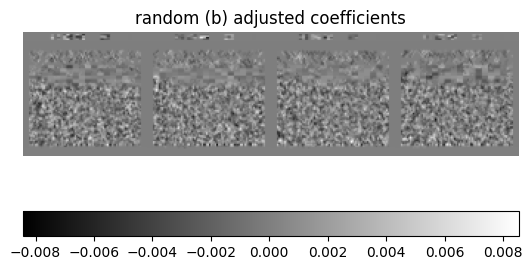

all lives (b) score: 1.0


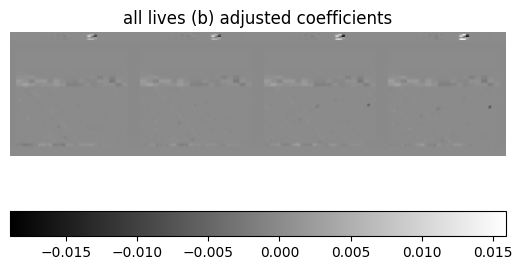

last life (b) score: 0.9961089494163424


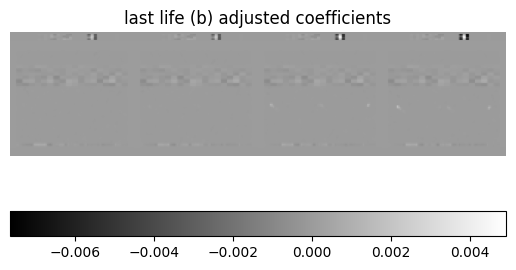

reward (b) score: 0.5925925925925926


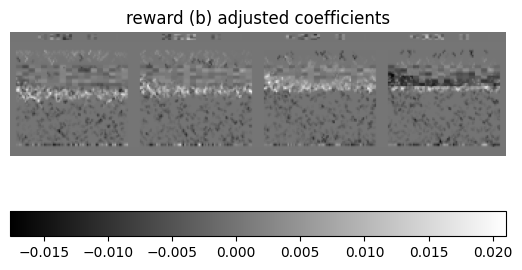

ball collision (b) score: 0.792


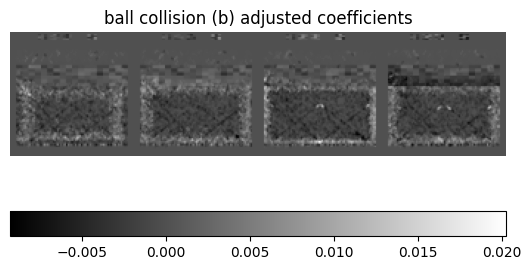

ball low (b) score: 0.9179999999999999


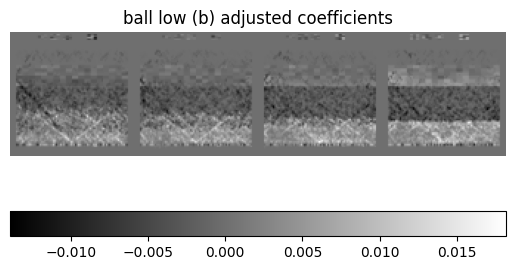

ball left paddle (b) score: 0.6719999999999999


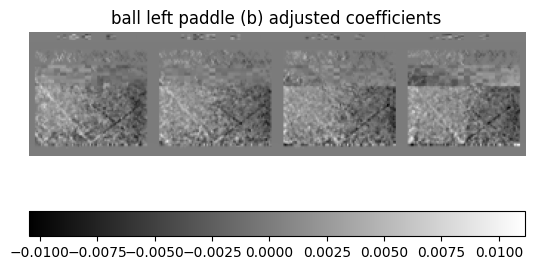

ball right paddle (b) score: 0.6739999999999999


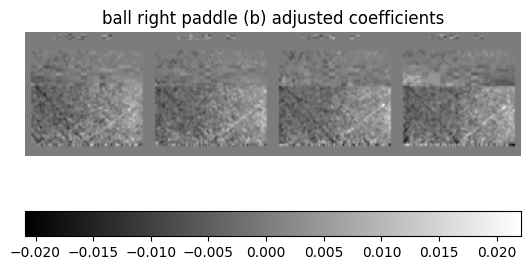

ball same x paddle (b) score: 0.43646408839779016


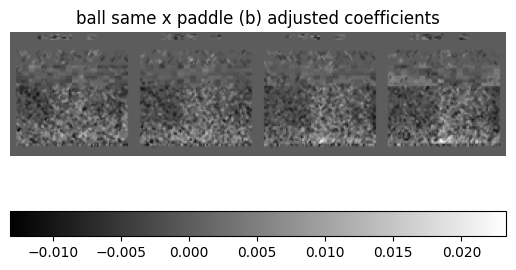

ball distance paddle score: 0.7405818120389449


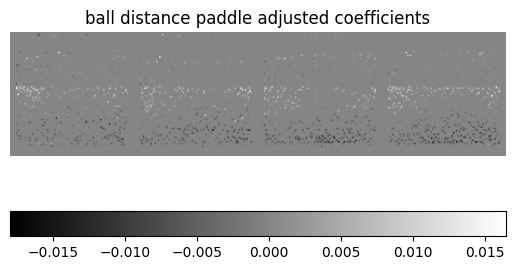

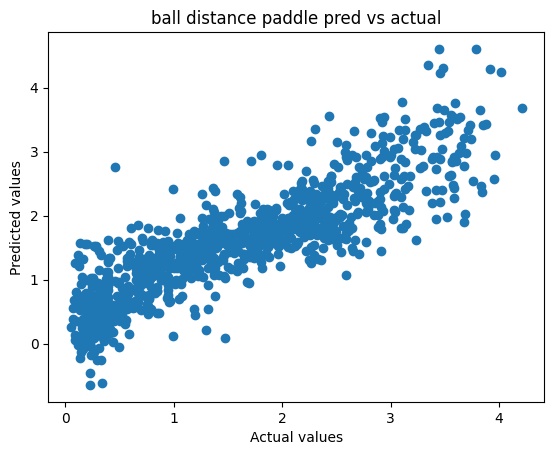

ball y score: 0.7501629684054212


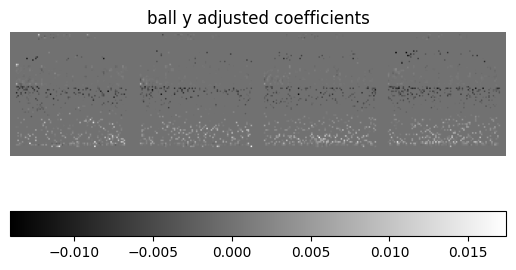

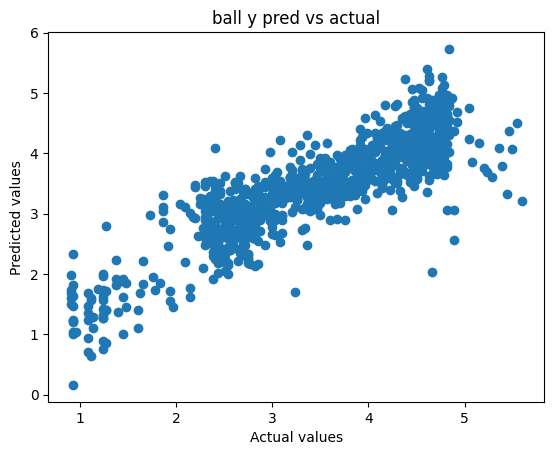

ball y next score: 0.7176275892951467


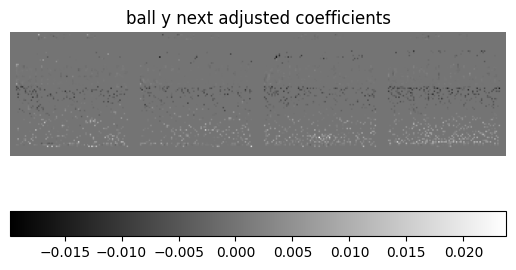

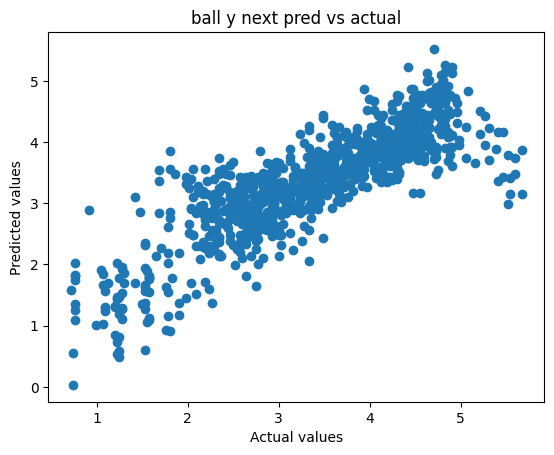

ball x score: 0.8045994254309947


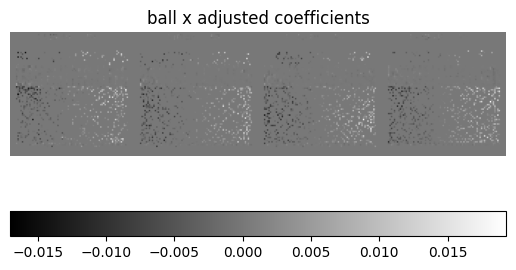

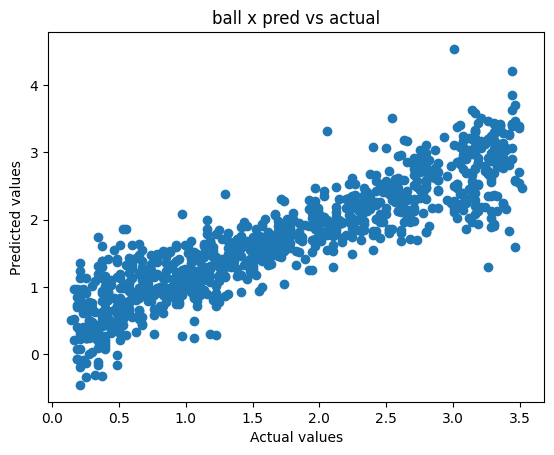

ball x next score: 0.7037374510242697


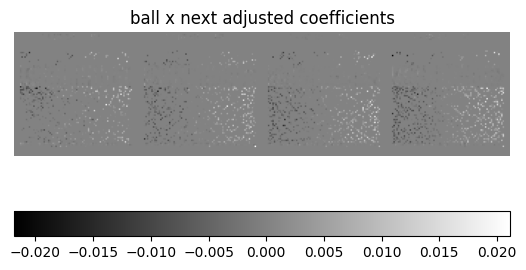

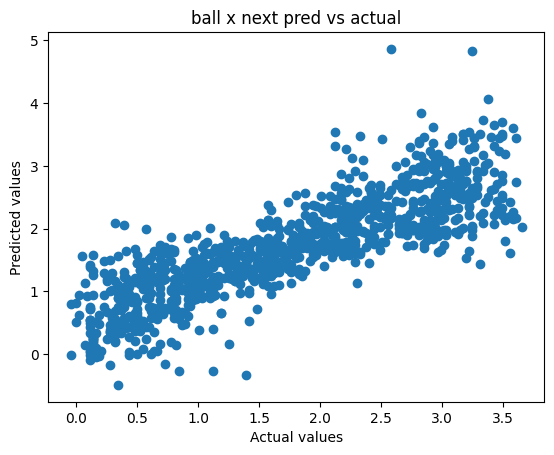

lives score: 0.9944620797553682


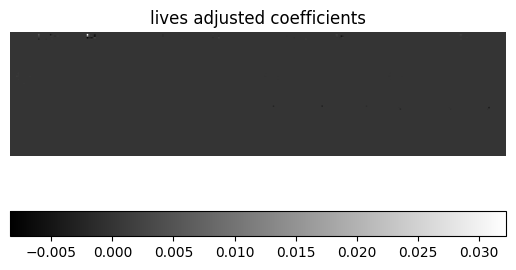

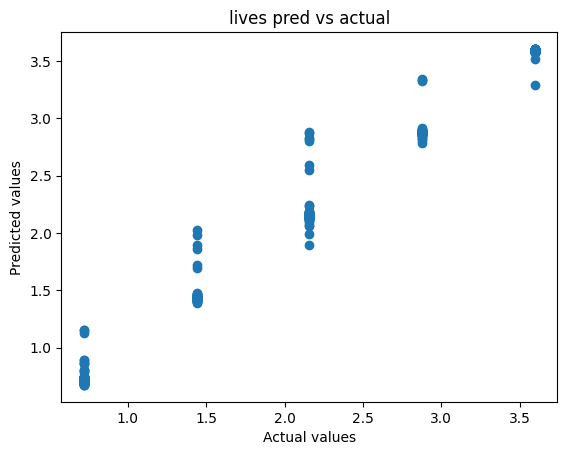

x diff score: 0.38223864447118394


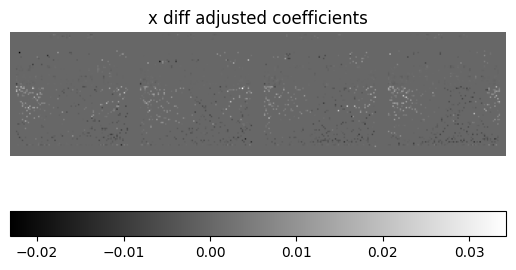

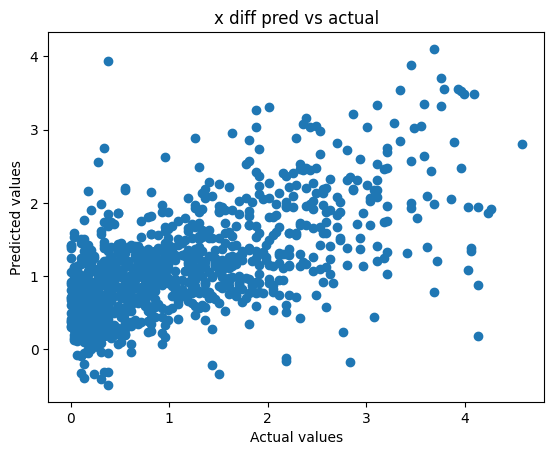

frames until collision horizontal score: 0.13334097074929108


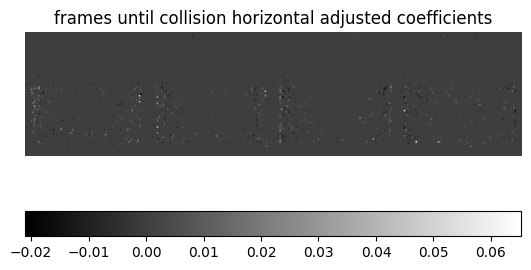

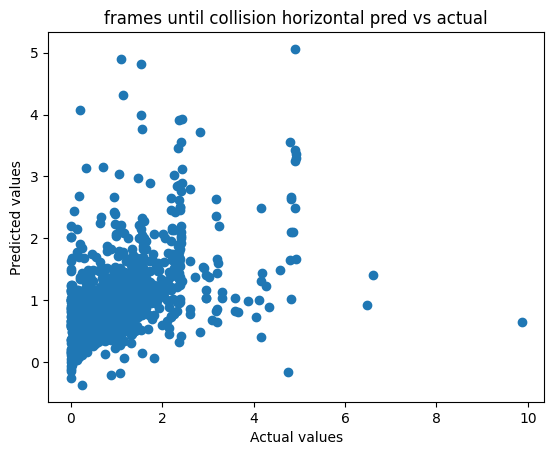

frames until collision vertical score: 0.11567065040584878


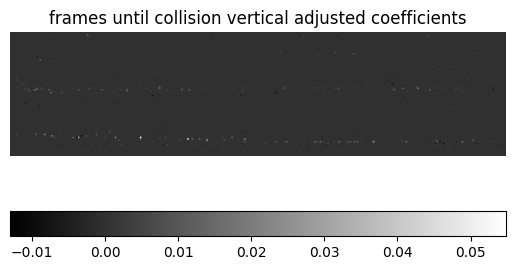

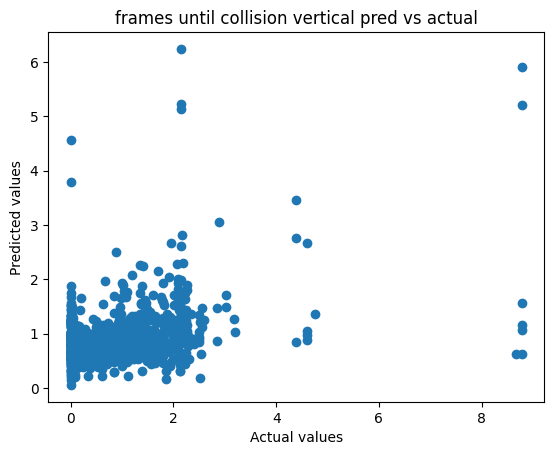

paddle x score: 0.9878610693182108


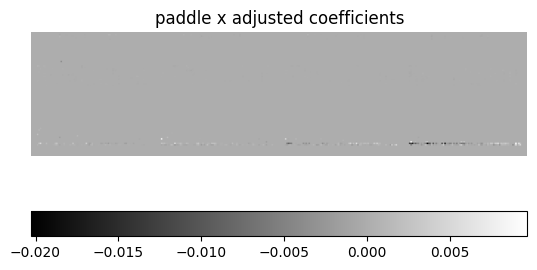

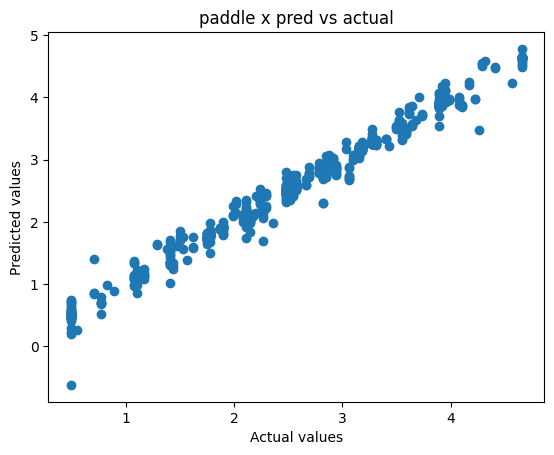

ball speed horizontal score: 0.4001362309085915


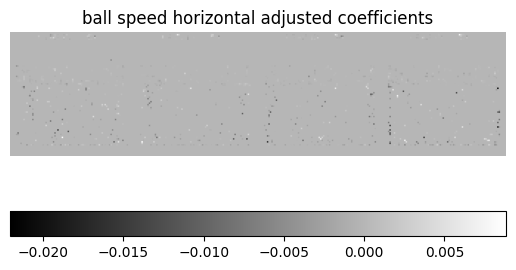

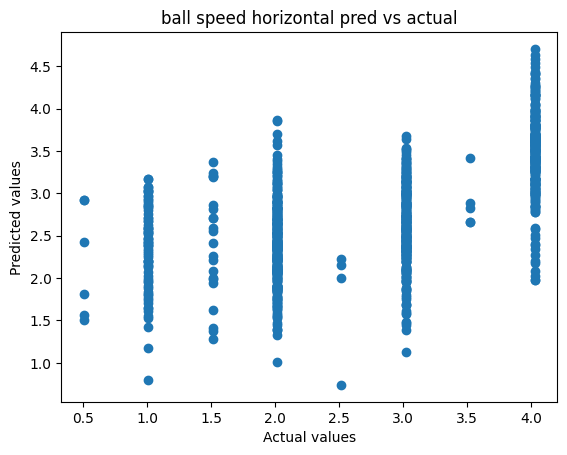

ball speed vertical score: 0.23500911338500297


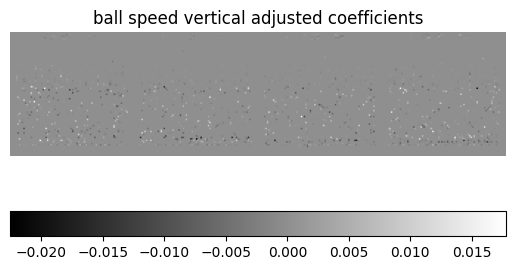

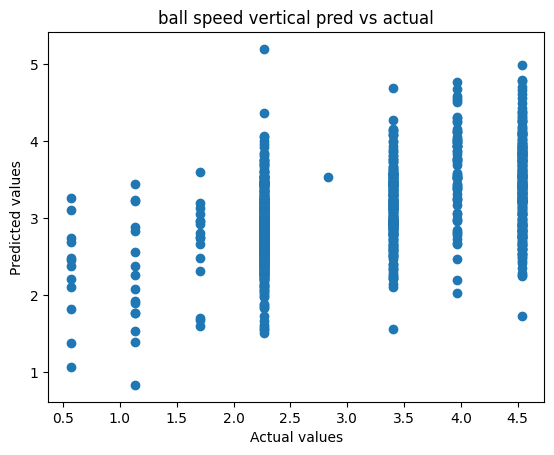

game steps score: 0.9957807321056837


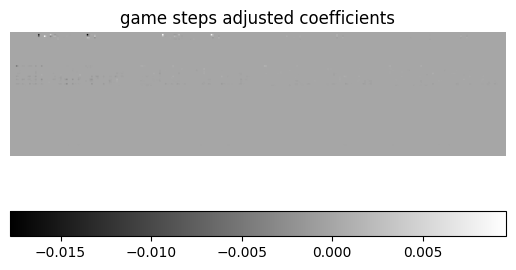

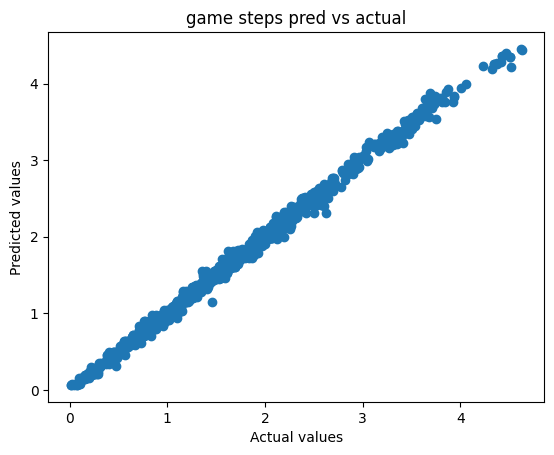

bricks hit score: 0.9984919198411587


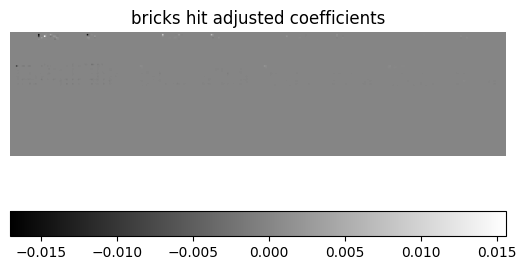

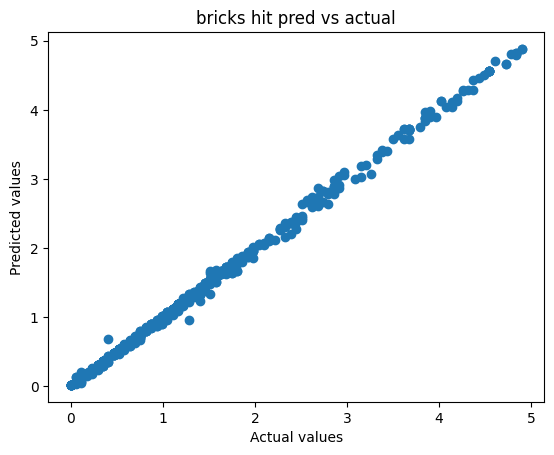

In [8]:
for concept in concept_instances.values():
    obs_train = concept.obs_train.reshape(len(concept.obs_train), -1)
    obs_test = concept.obs_test.reshape(len(concept.obs_test), -1)
    if concept.binary:
        reg, score = calculate_accuracy(obs_train, concept.values_train, obs_test, concept.values_test)
    else:
        reg, score = calculate_r2(obs_train, concept.values_train, obs_test, concept.values_test)
    print(f'{concept.name} score: {score}')

    # plot the coefficents of reg with grey scale
    coefs = np.concatenate(reg.coef_.reshape(4,84,84), axis=1)
    coefs = enhance_image(coefs, gamma=0.9)
    plt.imshow(coefs, cmap='gray')
    plt.colorbar(location='bottom')

    plt.axis('off')
    plt.axis('off')
    plt.title(f'{concept.name} adjusted coefficients')
    plt.show()

    # plot preds vs. true values if non-binary
    if not concept.binary:
        plt.scatter(concept.values_test, reg.predict(obs_test))
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title(f'{concept.name} pred vs actual')
        plt.show()